In [1]:
# inversion calculation
# following Feng 2009 ACP paper

In [2]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re
import cartopy.crs as ccrs
import pandas as pd
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from my custom Python script

In [4]:
case_name  = 'CO2-2018-04'
name_month = 'Apr' # Jan, Feb, Mar
imonth     =  4    # 1,2,3
mode       = 'N'  # 'N': Nadir or 'NG': Nadir + Glint

In [5]:
case_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/' + case_name + '/nd51/'
output_dir = case_dir
xco2_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018/nd51/'

if mode == 'N':
    delta_y0_file = 'delta_y0_model_N_' + name_month + '.nc'
    xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
else:
    delta_y0_file = 'delta_y0_model_' + name_month + '.nc'
    xco2_file = 'XCO2_mod_and_oco2_' + name_month + '.nc'

In [6]:
ds_delta_y0 = xr.open_dataset(case_dir + delta_y0_file)
varnames = list(ds_delta_y0.data_vars.keys())

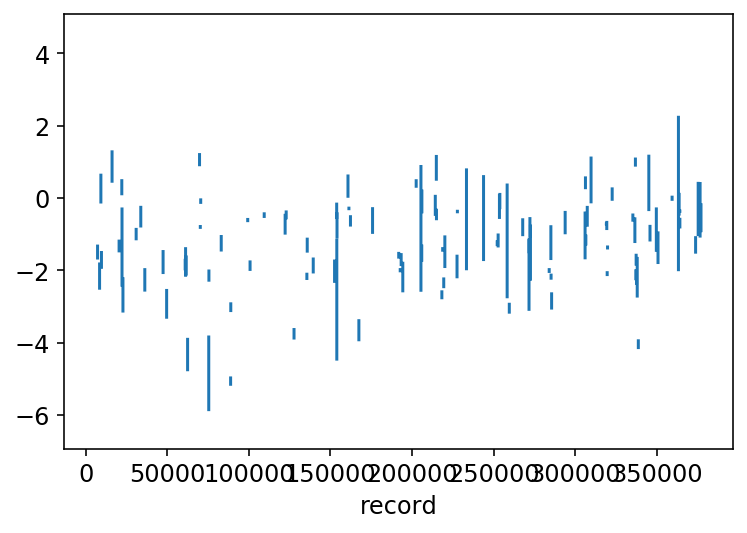

In [7]:
ds_xco2 = xr.open_dataset(xco2_dir + xco2_file)
diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
diff.plot()

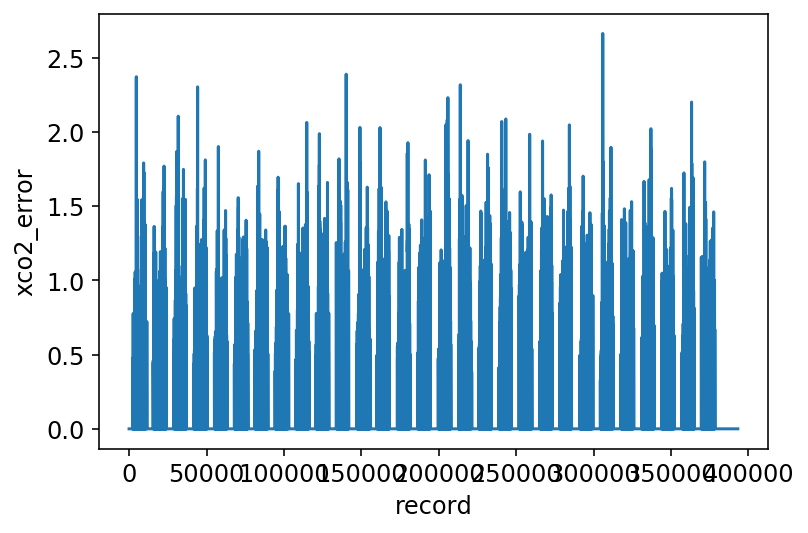

In [8]:
xco2_error = ds_xco2['xco2_error']
xco2_error.plot()

In [9]:
# reduce the size of all arrays and matrices, from 400k to <5k
xco2_oco2 = ds_xco2['xco2_oco2']
x = xco2_oco2.copy()
x = x[np.logical_not(np.isnan(x))]
ind = x.record.values # index for slicing
length = len(ind)
length

1416

(1416,)


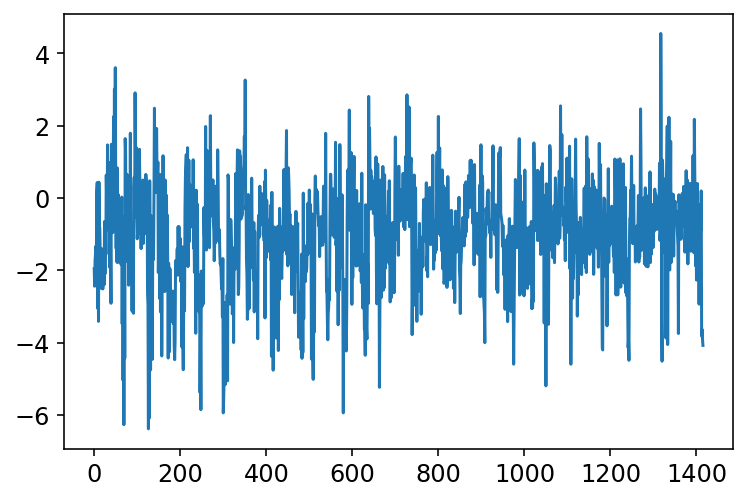

In [10]:
diff_slice = diff[ind].values
print(np.shape(diff_slice))
plt.plot(diff_slice) # same as above, excluded nan values

1416


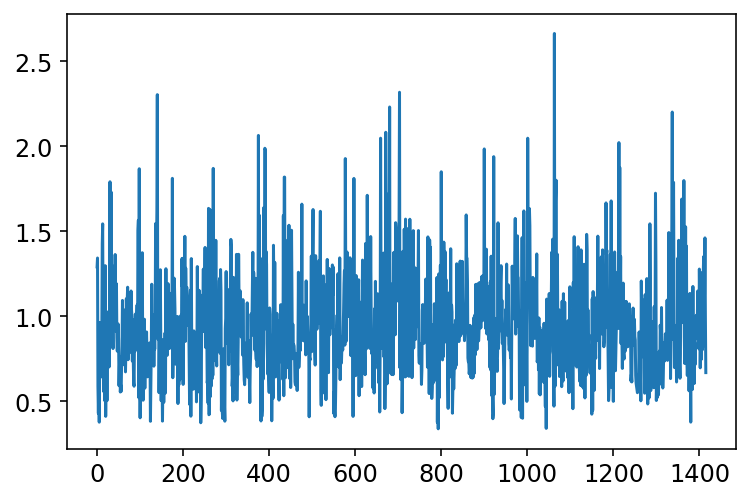

In [11]:
xco2_error_slice = xco2_error[ind].values
print(len(xco2_error_slice))
plt.plot(xco2_error_slice) # same as above, excluded nan values

In [12]:
del_Y_matrix = np.empty((length,22))
del_Y_matrix[:] = np.nan
print(np.shape(del_Y_matrix))

for itag in range(22):
    name_var = 'X_SpeciesConc_CO2Tag' + str(itag+1)
    del_Y_matrix[:,itag] = ds_delta_y0[name_var][ind].values

(1416, 22)


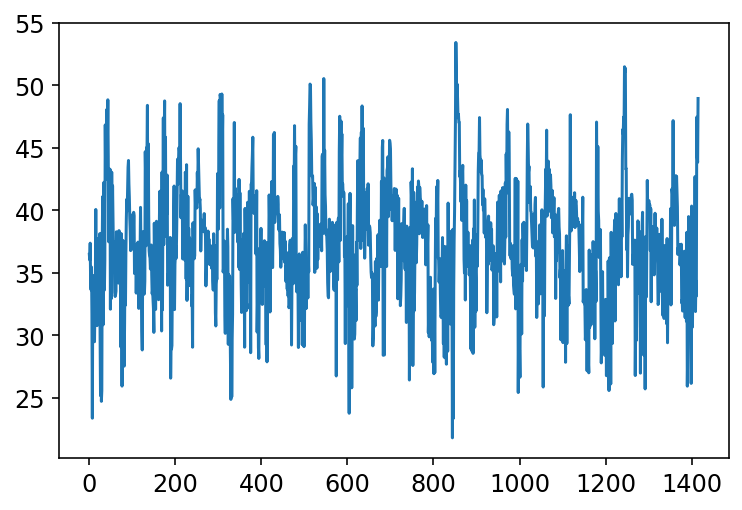

In [13]:
plt.plot(del_Y_matrix[:,5])

In [14]:
del_Y_tran = np.matrix.transpose(del_Y_matrix)
first = np.matmul(del_Y_matrix,del_Y_tran)
print(np.shape(first))
first

(1416, 1416)


array([[29294.84835357, 28926.61183546, 30013.50801644, ...,
        35642.46813624, 35146.49208811, 39316.94484678],
       [28926.61183546, 28563.00405448, 29636.23792353, ...,
        35194.44202525, 34704.70040473, 38822.73052893],
       [30013.50801644, 29636.23792353, 30749.79819538, ...,
        36516.84610913, 36008.70269231, 40281.46489751],
       ...,
       [35642.46813624, 35194.44202525, 36516.84610913, ...,
        43365.60545929, 42762.14813736, 47836.26739546],
       [35146.49208811, 34704.70040473, 36008.70269231, ...,
        42762.14813736, 42167.20300472, 47170.59226243],
       [39316.94484678, 38822.73052893, 40281.46489751, ...,
        47836.26739546, 47170.59226243, 52767.85044602]])

In [15]:
obs_error = np.zeros((length,length))
print(np.shape(obs_error))
for idiag in range(length):
    obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + 2.5 #
obs_error

(1416, 1416)


array([[4.16746138, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.30482446, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.84540833, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 4.63666192, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 3.50139404,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.94821859]])

In [16]:
second = np.linalg.inv(first+obs_error)
second

array([[ 2.39764976e-01, -1.80724551e-04, -2.91085406e-04, ...,
        -9.64796756e-05, -1.30339689e-04, -2.03193089e-04],
       [-1.80724551e-04,  2.32124907e-01, -2.77034368e-04, ...,
        -9.27690493e-05, -1.25070648e-04, -1.95413848e-04],
       [-2.91085406e-04, -2.77034368e-04,  3.50961259e-01, ...,
        -1.24674878e-04, -1.78104538e-04, -2.61366071e-04],
       ...,
       [-9.64796756e-05, -9.27690490e-05, -1.24674879e-04, ...,
         2.14082672e-01, -4.97201368e-04, -2.71180930e-03],
       [-1.30339689e-04, -1.25070648e-04, -1.78104538e-04, ...,
        -4.97201367e-04,  2.83311836e-01, -1.04742841e-03],
       [-2.03193089e-04, -1.95413848e-04, -2.61366071e-04, ...,
        -2.71180930e-03, -1.04742841e-03,  3.32062617e-01]])

In [17]:
third = np.matmul(del_Y_tran,second)
print(np.shape(third))
third

(22, 1416)


array([[-0.00092113, -0.0008718 , -0.0017061 , ..., -0.00373206,
        -0.00318718, -0.00843785],
       [ 0.00099222,  0.00081772,  0.0063421 , ..., -0.00280977,
        -0.00244625, -0.00608848],
       [-0.00051401, -0.00046255, -0.00184018, ..., -0.00276358,
        -0.00229827, -0.00575053],
       ...,
       [ 0.00069842,  0.00067492,  0.00077812, ..., -0.0028315 ,
        -0.00236936, -0.0056659 ],
       [-0.0004815 , -0.00045542, -0.00090335, ...,  0.02318114,
        -0.00680815,  0.02125646],
       [-0.00029652, -0.00027457, -0.00077353, ...,  0.01172318,
         0.00578738,  0.06092928]])

In [18]:
del_X_f = np.zeros((22,22))
for idiag in range(22):
    del_X_f[idiag,idiag] = 1.0  # GtC/yr
del_X_f_inv = np.linalg.inv(del_X_f)

In [19]:
k_e = np.matmul(del_X_f,third)
print(np.shape(k_e))
k_e

(22, 1416)


array([[-0.00092113, -0.0008718 , -0.0017061 , ..., -0.00373206,
        -0.00318718, -0.00843785],
       [ 0.00099222,  0.00081772,  0.0063421 , ..., -0.00280977,
        -0.00244625, -0.00608848],
       [-0.00051401, -0.00046255, -0.00184018, ..., -0.00276358,
        -0.00229827, -0.00575053],
       ...,
       [ 0.00069842,  0.00067492,  0.00077812, ..., -0.0028315 ,
        -0.00236936, -0.0056659 ],
       [-0.0004815 , -0.00045542, -0.00090335, ...,  0.02318114,
        -0.00680815,  0.02125646],
       [-0.00029652, -0.00027457, -0.00077353, ...,  0.01172318,
         0.00578738,  0.06092928]])

In [20]:
adjust = np.matmul(k_e, diff_slice)
adjust

array([ 1.39634071,  0.28955014,  1.02276875, -0.60796109,  0.27145561,
        0.47336235,  0.36719552,  0.07624032, -0.18599734,  0.47359685,
       -1.06131712,  0.43488918,  0.82640033,  1.38709626,  2.25230697,
       -1.18474359, -0.88657088, -0.57777254, -0.47811043,  0.74771333,
       -3.5139554 , -1.54775751])

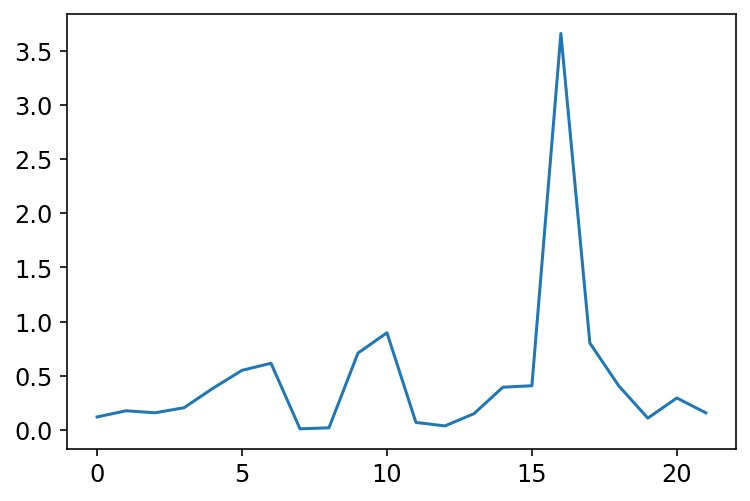

In [21]:
df = pd.read_csv('/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/base_emission.csv')
region_names = df['name'].values
prior_emission = df['emission'].values
plt.plot(prior_emission)

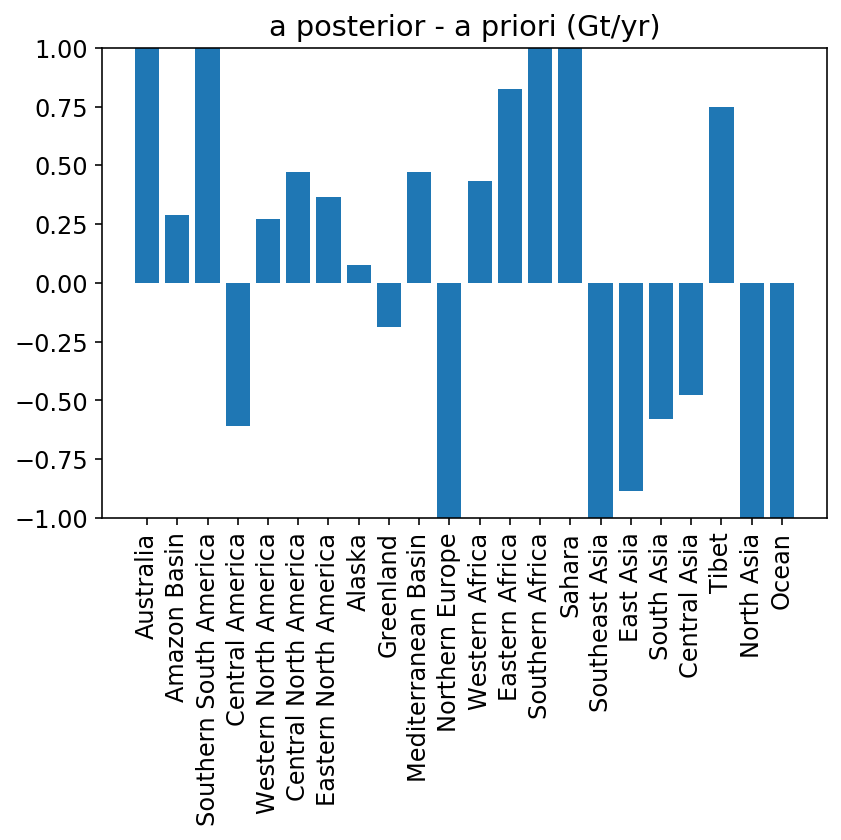

In [22]:
# first attempt
fig = plt.figure(figsize=[6, 6])
plt.bar(region_names, adjust)
plt.ylim(top   = 1,bottom = -1)
plt.title('a posterior - a priori (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_dir+'adjustment_' + name_month +'.png', dpi=300)

shape of k_e:  (22, 1416)


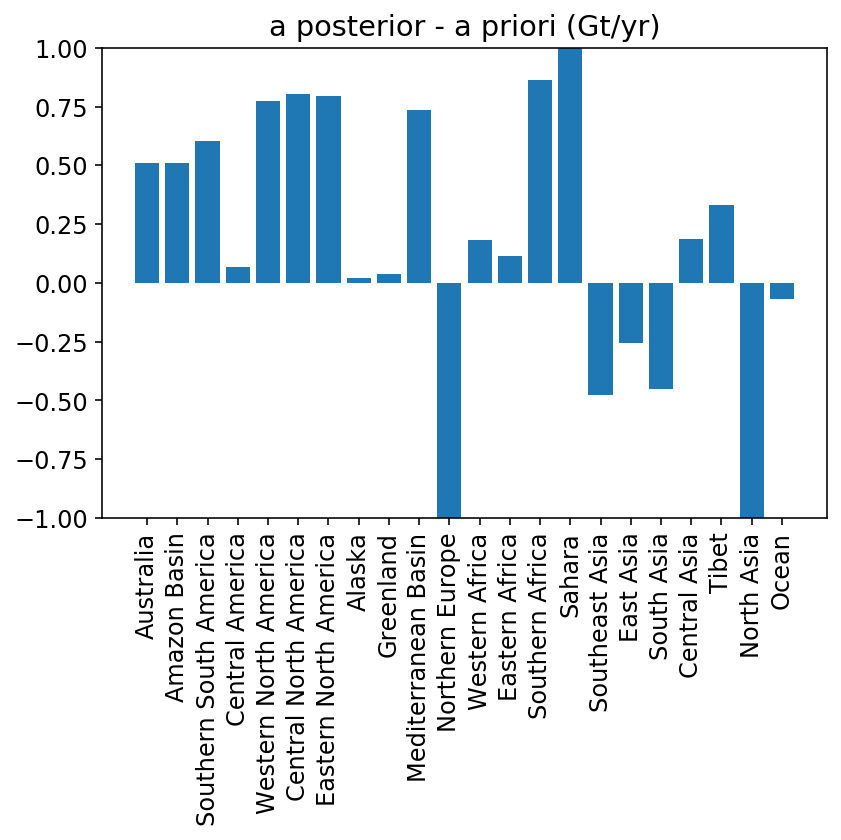

In [23]:
# different algorithm
X_f = np.zeros((22,22))
for idiag in range(22):
    X_f[idiag,idiag] = prior_emission[idiag]
mul1 = np.matmul(del_X_f_inv, X_f)
del_Y = np.matmul(del_Y_matrix, mul1)
Y_tran = np.matrix.transpose(del_Y)
first = np.matmul(del_Y,Y_tran)
second = np.linalg.inv(first+obs_error)
third = np.matmul(Y_tran,second)
k_e = np.matmul(del_X_f,third)
print('shape of k_e: ', k_e.shape)
adjust = np.matmul(k_e, diff_slice)

fig = plt.figure(figsize=[6, 6])
plt.bar(region_names, adjust)
plt.ylim(top   = 1,bottom = -1)
plt.title('a posterior - a priori (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_dir+'adjustment_' + name_month +'.png', dpi=300)

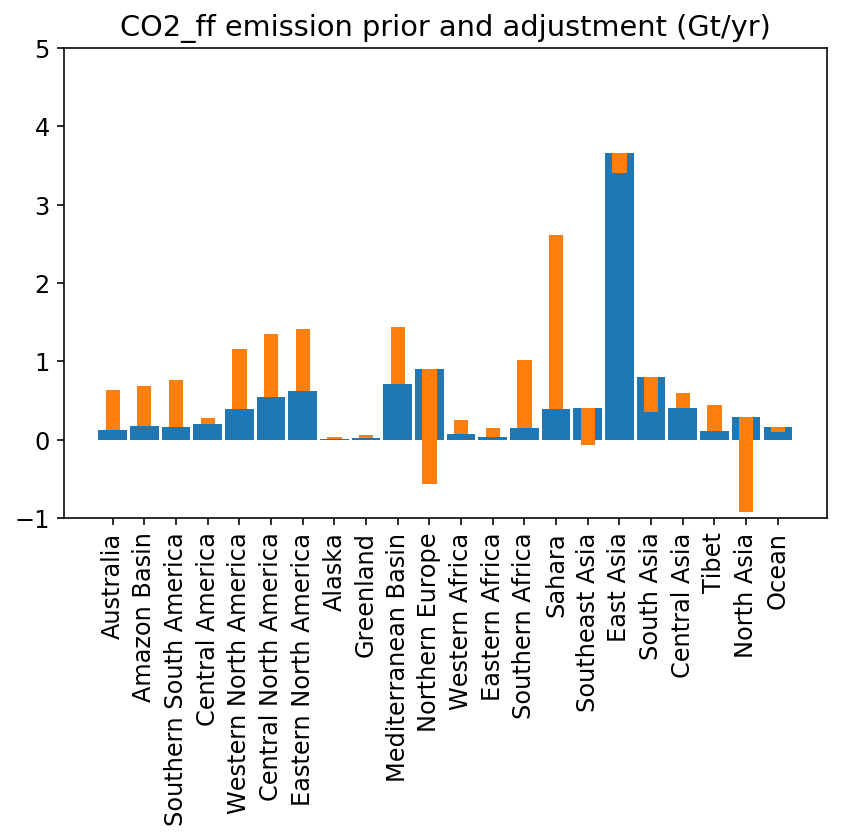

In [24]:
fig = plt.figure(figsize=[6, 6])
width = 0.9
plt.bar(region_names, prior_emission, width)
plt.bar(region_names, adjust,         width*0.5, bottom = prior_emission)
plt.ylim(top   = 5,bottom = -1)
plt.title('CO2_ff emission prior and adjustment (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_dir+'posterior_' + name_month +'.png', dpi=300)